In [21]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader, ImbalancedSampler
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention, SAGEConv

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os
from typing import Optional

from torch_scatter import scatter_add

from torch_geometric.utils import softmax

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters, visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT
from graph_training import train_model, test_model, _vis_graph_example, train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

### Load Data


In [3]:
orig_df = pd.read_csv(os.path.abspath('/home/sneha/toy_normalised_0607.csv'))
orig_df.describe()

label_df = pd.read_csv(os.path.abspath('/home/sneha/toy_labels_0607.csv'))
label_df

,idno,startbpid,endbpid,graph_label,node_label
0,3010007,-1.0,1.0,0,0
1,3010007,1.0,3.0,0,0
2,3010007,1.0,2.0,0,0
3,3010007,2.0,4.0,0,0
4,3010007,2.0,5.0,0,0
...,...,...,...,...,...
136973,8024782,204.0,263.0,1,0
136974,8024782,262.0,303.0,1,0
136975,8024782,262.0,304.0,1,0
136976,8024782,263.0,305.0,1,0


In [4]:
# delete a lobe
# orig_df = orig_df.loc[((orig_df.binaryLL_1 == 1) & (orig_df.lobe != 2)) | (orig_df.binaryLL_1 == 0)]
# test.loc[test.binaryLL_1 == 1].groupby('lobe').agg('count')

In [5]:
# label_df = orig_df[['idno', 'binaryLL_1']].drop_duplicates()
# label_df

### Train test split mask

In [6]:
label_col_name = 'node_label'

In [7]:
train_ids, test_ids = train_test_split(label_df, n_splits_test = 5, label_col_name= label_col_name, seed=0)

pilot_df_train = orig_df.loc[orig_df.idno.isin(train_ids)]
pilot_df_test = orig_df.loc[orig_df.idno.isin(test_ids)]
binary_label_df_train = label_df.loc[label_df.idno.isin(train_ids)]
binary_label_df_test = label_df.loc[label_df.idno.isin(test_ids)]
print("Overall Label frequency distribution", [(x, binary_label_df_test[label_col_name].tolist().count(x)) for x in set(binary_label_df_test[label_col_name].tolist())])


# SAVE PILOT DF for training
pilot_df_train.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv')
binary_label_df_train.to_csv('/home/sneha/toy_lobe_binary_labels_train.csv')
pilot_df_test.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv')
binary_label_df_test.to_csv('/home/sneha/toy_lobe_binary_labels_test.csv')

Overall Label frequency distribution [(0, 135936), (1, 1042)]
Getting train test split stratified on the 136978 labels
Overall Label frequency distribution [(0, 135936), (1, 1042)]


In [8]:

def _vis_graph_example_2(dataloader,model, index, pilot_df_w_labels, device,visualise_g = False, save_path = None):
    data = dataloader.dataset[index]
    print(data)
    label = data.y
    g = to_networkx(data)
    # get relabelmap
    idno, relabel = dataloader.dataset.node_map[index]
    # map to original df
    vis_graph  =pilot_df_w_labels.loc[pilot_df_w_labels.idno==idno]
    print(f"This graph is for id: {idno}")
    display(vis_graph.head())
    # get the relabelling to match the pytorch graph 
    vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
    vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])
#     display(vis_graph[['startbpid', 'endbpid']+node_features + ['parent_loc_x_norm','parent_loc_y_norm']])
#     print(data.x)
    print("Getting model preds per node (node model needs to be a per node one)")
    model.eval()
    x, weight = model(data.to(device))
    print("weight", len(weight[0]))
    x = x.cpu().detach().numpy() # take off cuda
    
    weight = weight[0].cpu().detach().numpy() # take first item take off cuda
    
#     print("x", x.shape[0], 'weight', weight.shape[0], 'label', label.shape[0])
    
    if model.agg == 'none':
#         print('useing node preds')
        # per node rather than per graph
        preds = x.copy().squeeze()
    else:
        # per graph output - use per node (weights )for color
#         print("using weights")
        preds = weight.copy().squeeze()
#     print("preds shape", preds.shape)
    
    
    # drawing graph in networkx & matplotlib
    cmap = mpl.colormaps['spring'].reversed()
    vmin, vmax = min(weight), max(weight)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cmap_nodes = [cmap(norm(preds[node])) for node in g.nodes()]
    edge_labels = {edge:vis_graph.loc[vis_graph.end_node == edge[1]]['anatomicalname'].item() for edge in g.edges()}
    pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)
    
    
    if visualise_g:
        f, ax = plt.subplots(figsize=(10,10))
        nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
        nx.draw_networkx_edge_labels(g, pos,
                                  edge_labels,
                                     font_color='k',
                                     font_size='10',
                                  label_pos=0.5,

                                    )
        
        cbar = plt.colorbar(sm)

        plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
        plt.show()


    
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for i in range(len(vis_graph)):
        row = vis_graph.iloc[i]
        ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=1, color= cmap(norm(preds[row.end_node])), label=row.end_node)
        ax.scatter(row.x, row.y, row.z, marker='o',color= cmap(norm(preds[row.end_node])))
    ax.grid(False)
    ax.set_facecolor(color=(1,1,1))
    cbar = plt.colorbar(sm)
    plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


### Training Pipeline

In [ ]:
run_id = 5
try:
    os.makedirs(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/')
except:
    pass

verbose= True
# device = set_device_and_seed(GPU=True, gpu_name='cuda:0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

batch_size = 128
num_epochs = 100
count_epochs = 0
test_every = 5
weighted_loss = False
model_agg = 'none'
dropout = 0.2
hidden_dim1 = 8
hidden_dim2 = 8
lr=0.01
weight_decay=5e-4

In [24]:


#  removed from features for toy example, added edge features to node ones too just in case
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm',
                 'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm',
                'lobe_norm','sublobe_norm']
edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# DATASETS
my_data_train  = CustomDataset('data_train_toy/',
                               '/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv',
                               "/home/sneha/toy_lobe_binary_labels_train.csv",
                               args = args,
                               label_col_name=label_col_name
                              )

my_data_test  = CustomDataset('data_test_toy/', 
                              '/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv',
                              "/home/sneha/toy_lobe_binary_labels_test.csv",
                              args = args,
                              label_col_name=label_col_name
                             )



Using Node features: ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm', 'lobe_norm', 'sublobe_norm'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 136978 Label Frequency Counter({0: 135936, 1: 1042})
Class proportions: {0: 0.9923929390121041, 1: 0.007607060987895866}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:14<00:00, 142.65it/s]
Done!


Using Node features: ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm', 'lobe_norm', 'sublobe_norm'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 136978 Label Frequency Counter({0: 135936, 1: 1042})
Class proportions: {0: 0.9923929390121041, 1: 0.007607060987895866}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:14<00:00, 146.97it/s]
Done!


AssertionError: 

In [30]:
print(my_data_train.y)
sampler_train = ImbalancedSampler(my_data_train, num_samples=-1)

# train_loader = DataLoader(my_data_train, batch_size=batch_size, sampler = sampler_train, shuffle=True)

from torch_geometric.loader import NeighborLoader, ImbalancedSampler

train_loader = NeighborLoader(my_data_train,num_neighbors= -1, sampler=sampler_train, batch_size=batch_size, shuffle=False)
# loader = NeighborLoader(data, input_nodes=data.train_mask,
#                         batch_size=64, num_neighbors=[-1, -1],
#                         sampler=sampler, ...)


test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)

AttributeError: 'CustomDataset' object has no attribute 'y'

In [ ]:
class MyGCN(torch.nn.Module):
    '''
    Simple GNN for graph preds
    hidden_channels = [8,8,8] for now
    
    '''
    def __init__(self, in_channels, hidden_channels = 8, out_channels= 1, dropout=0.2):
        super(MyGCN, self).__init__()
        self.dropout=dropout
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,hidden_channels)
        self.conv3 = GCNConv(hidden_channels,hidden_channels)
        self.lin =  nn.Sequential(
                                        nn.Linear(hidden_channels, out_channels),
                                        nn.Sigmoid()
                                    )
        

    def forward(self, data):
        x, edge_index,  batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        
        return x, None
    
    


# class GlobalAttentionNet(torch.nn.Module):
#     '''
#     Does per node predictions
    
    
#     '''
#     def __init__(self, in_channels, out_channels, num_layers, hidden):
        
#         super().__init__()
#         self.conv1 = SAGEConv(in_channels, hidden)
#         self.convs = torch.nn.ModuleList()
#         for i in range(num_layers - 1):
#             self.convs.append(SAGEConv(hidden, hidden))
#         self.att = GlobalAttention(Linear(hidden, 1))
#         self.lin1 = Linear(hidden, hidden)
#         self.lin2 = Linear(hidden, out_channels)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = F.relu(self.conv1(x, edge_index))
#         for conv in self.convs:
#             x = F.relu(conv(x, edge_index))
#         x = self.att(x, batch)
#         x = F.relu(self.lin1(x))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin2(x)
#         return F.log_softmax(x, dim=-1)

#     def __repr__(self):
#         return self.__class__.__name__

model = MyGCN(in_channels=13, hidden_channels=8, out_channels=1)
model

In [23]:

# make training function
def train_model(model, 
                optimizer,
                train_loader, 
                device,
                num_epochs, 
                count_epochs=0,
                verbose=True, 
                scheduler=None, 
                accum_iter=1, 
                class_weight=None):
    
    plotting_dict_train = {"loss":[], "accuracy": []}
    noisy_label=False
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        denominator_loss = 0
        denominator_acc=0
        for batch_idx, data in list(enumerate(train_loader)):
            data = data.to(device)
            batch_size = data.num_graphs
            batch_vector = data.batch
            denominator_loss+=batch_size
            # reset gradients
            if batch_idx % accum_iter ==0:
                optimizer.zero_grad()

            # conduct a forward pass
            out, weight = model(data)
#             print("out", out.shape, out)
            y_per_graph = data.y.float()
            
              # Noisy vs per graph labelling depending on model type
            if (out.squeeze()).shape != data.y.shape:
                noisy_label = True
                y = torch.take(data.y.float(), batch_vector) # repeat label shape
#                 print('Noisy labelling', y.shape)
                # denominator for accuracy etc. is y.shape from here (to average out per node accuracy)
            else:
                y = data.y.float()
                print('Not changing label format', y.shape, 'balance', y.sum()/len(y))
                # denominatro here is y.shape (per graph to avg out graph accuracy)
#             print(y.shape[0])
            denominator_acc +=y.shape[0]
            # calculate loss and metrics
            pred = out > 0.5
            pred = pred.long()
#             print(pred.unique())
            correct += pred.eq(y.view_as(pred)).sum().item()
            
            
            if class_weight is not None:
                weights = torch.take(class_weight.to(device), y.long()) # class_weight has weight for 0 in posnt 0 and 1 in 1
#                 print("weights", weights, y, sep='\n')
                loss = F.binary_cross_entropy(out.squeeze(),y.float(), weight=weights.float())
            else:
                loss = F.binary_cross_entropy(out.squeeze(),y)
                
#             print("loss", loss)
            train_loss += loss.item()

            # backward pass, normalising for gradient accumulation
            loss = loss / accum_iter
            loss.backward()
            
            # step
            if (batch_idx % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()

                
            if verbose:
                print('Epoch: {}, Batch: {}, Loss: {:.2f}'.format(epoch+count_epochs, batch_idx, loss.item()))
        # calculate loss and error for epoch
        train_loss /= denominator_loss # loss is already mean over the nodes so just divide by num graphs in batch
        accuracy = correct / denominator_acc # if doing noisy labelling need to do length of vector
        plotting_dict_train["loss"].append(train_loss)
        plotting_dict_train["accuracy"].append(accuracy)
        
        # step at the end of each epoch
        if scheduler is not None:
            scheduler.step()
            
            if scheduler is not None:
                last_lr = scheduler.get_last_lr()[0]
            
        print('Epoch: {}, Train Loss: {:.5f}, Train Accuracy: {:.5f}'.format(epoch+count_epochs, train_loss, accuracy))
        
    return plotting_dict_train


class weights for weighted loss tensor([0.0076, 0.9924], dtype=torch.float64)
15
cuda
GAT(
  (conv1): GATConv(15, 8, heads=8)
  (conv2): GATConv(64, 8, heads=8)
  (lin1): Linear(in_features=8, out_features=1, bias=True)
  (att): CustomGlobalAttention(gate_nn=Linear(in_features=8, out_features=1, bias=True), nn=None)
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Training epochs: 0 to 5 
Epoch: 0, Batch: 0, Loss: 0.02
Epoch: 0, Batch: 1, Loss: 0.01
Epoch: 0, Batch: 2, Loss: 0.01
Epoch: 0, Batch: 3, Loss: 0.01
Epoch: 0, Batch: 4, Loss: 0.01
Epoch: 0, Batch: 5, Loss: 0.00
Epoch: 0, Batch: 6, Loss: 0.00
Epoch: 0, Batch: 7, Loss: 0.02
Epoch: 0, Batch: 8, Loss: 0.01
Epoch: 0, Batch: 9, Loss: 0.01
Epoch: 0, Batch: 10, Loss: 0.00
Epoch: 0, Batch: 11, Loss: 0.01
Epoch: 0, Batch: 12, Loss: 0.01
Epoch: 0, Batch: 13, Loss: 0.01
Epoch: 0, Batch: 14, Loss: 0.01
Epoch: 0, Batch: 15, Loss: 0.02
Epoch: 0, Batch: 16, Loss: 0.00
Epoch: 0, Tr

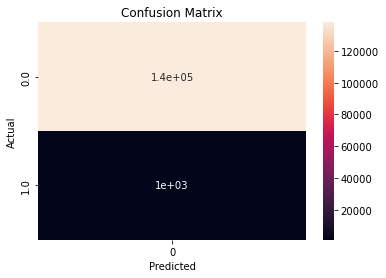

Visualise training progress


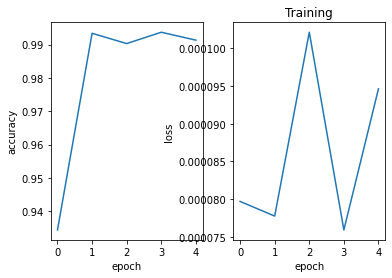

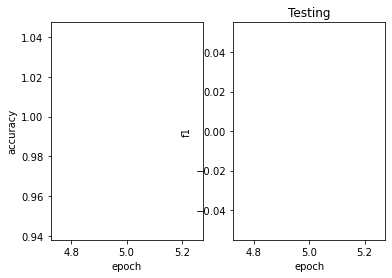

Training epochs: 5 to 10 
Epoch: 5, Batch: 0, Loss: 0.01
Epoch: 5, Batch: 1, Loss: 0.01
Epoch: 5, Batch: 2, Loss: 0.01
Epoch: 5, Batch: 3, Loss: 0.02
Epoch: 5, Batch: 4, Loss: 0.02
Epoch: 5, Batch: 5, Loss: 0.02
Epoch: 5, Batch: 6, Loss: 0.02
Epoch: 5, Batch: 7, Loss: 0.01
Epoch: 5, Batch: 8, Loss: 0.02
Epoch: 5, Batch: 9, Loss: 0.01
Epoch: 5, Batch: 10, Loss: 0.02
Epoch: 5, Batch: 11, Loss: 0.01
Epoch: 5, Batch: 12, Loss: 0.02
Epoch: 5, Batch: 13, Loss: 0.01
Epoch: 5, Batch: 14, Loss: 0.02
Epoch: 5, Batch: 15, Loss: 0.01
Epoch: 5, Batch: 16, Loss: 0.01
Epoch: 5, Train Loss: 0.00010, Train Accuracy: 0.68525
Epoch: 6, Batch: 0, Loss: 0.02
Epoch: 6, Batch: 1, Loss: 0.01
Epoch: 6, Batch: 2, Loss: 0.01
Epoch: 6, Batch: 3, Loss: 0.01
Epoch: 6, Batch: 4, Loss: 0.01
Epoch: 6, Batch: 5, Loss: 0.02
Epoch: 6, Batch: 6, Loss: 0.01
Epoch: 6, Batch: 7, Loss: 0.02
Epoch: 6, Batch: 8, Loss: 0.01
Epoch: 6, Batch: 9, Loss: 0.02
Epoch: 6, Batch: 10, Loss: 0.01
Epoch: 6, Batch: 11, Loss: 0.01
Epoch: 6, B

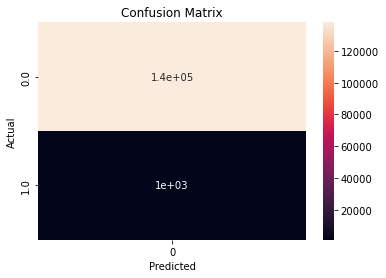

Visualise training progress


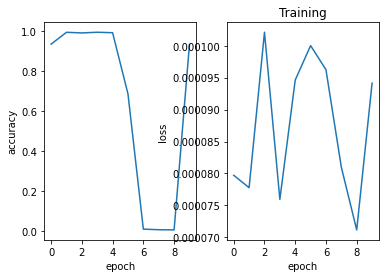

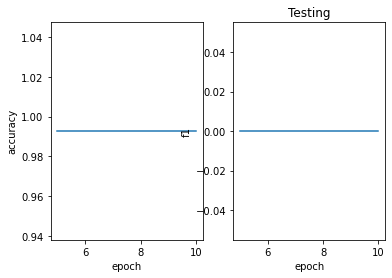

Training epochs: 10 to 15 
Epoch: 10, Batch: 0, Loss: 0.01
Epoch: 10, Batch: 1, Loss: 0.01
Epoch: 10, Batch: 2, Loss: 0.01
Epoch: 10, Batch: 3, Loss: 0.01
Epoch: 10, Batch: 4, Loss: 0.01
Epoch: 10, Batch: 5, Loss: 0.01
Epoch: 10, Batch: 6, Loss: 0.01
Epoch: 10, Batch: 7, Loss: 0.02
Epoch: 10, Batch: 8, Loss: 0.01
Epoch: 10, Batch: 9, Loss: 0.01
Epoch: 10, Batch: 10, Loss: 0.01
Epoch: 10, Batch: 11, Loss: 0.02
Epoch: 10, Batch: 12, Loss: 0.01
Epoch: 10, Batch: 13, Loss: 0.01
Epoch: 10, Batch: 14, Loss: 0.01
Epoch: 10, Batch: 15, Loss: 0.01
Epoch: 10, Batch: 16, Loss: 0.01
Epoch: 10, Train Loss: 0.00008, Train Accuracy: 0.53845
Epoch: 11, Batch: 0, Loss: 0.01
Epoch: 11, Batch: 1, Loss: 0.01
Epoch: 11, Batch: 2, Loss: 0.02
Epoch: 11, Batch: 3, Loss: 0.01
Epoch: 11, Batch: 4, Loss: 0.01
Epoch: 11, Batch: 5, Loss: 0.02
Epoch: 11, Batch: 6, Loss: 0.01
Epoch: 11, Batch: 7, Loss: 0.01
Epoch: 11, Batch: 8, Loss: 0.01
Epoch: 11, Batch: 9, Loss: 0.01
Epoch: 11, Batch: 10, Loss: 0.01
Epoch: 11, Ba

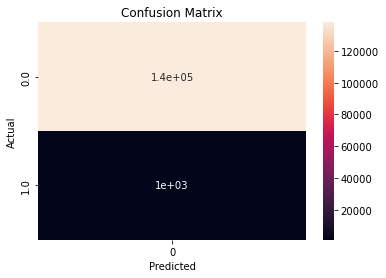

Visualise training progress


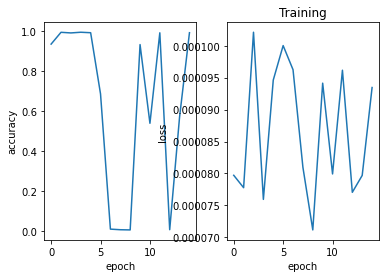

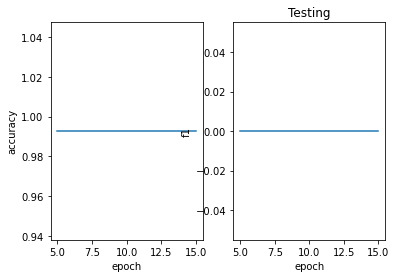

Training epochs: 15 to 20 
Epoch: 15, Batch: 0, Loss: 0.01
Epoch: 15, Batch: 1, Loss: 0.01
Epoch: 15, Batch: 2, Loss: 0.02
Epoch: 15, Batch: 3, Loss: 0.01
Epoch: 15, Batch: 4, Loss: 0.01
Epoch: 15, Batch: 5, Loss: 0.01
Epoch: 15, Batch: 6, Loss: 0.02
Epoch: 15, Batch: 7, Loss: 0.01
Epoch: 15, Batch: 8, Loss: 0.02
Epoch: 15, Batch: 9, Loss: 0.01
Epoch: 15, Batch: 10, Loss: 0.01
Epoch: 15, Batch: 11, Loss: 0.01
Epoch: 15, Batch: 12, Loss: 0.01
Epoch: 15, Batch: 13, Loss: 0.01
Epoch: 15, Batch: 14, Loss: 0.02
Epoch: 15, Batch: 15, Loss: 0.01
Epoch: 15, Batch: 16, Loss: 0.01
Epoch: 15, Train Loss: 0.00008, Train Accuracy: 0.99351
Epoch: 16, Batch: 0, Loss: 0.01
Epoch: 16, Batch: 1, Loss: 0.01
Epoch: 16, Batch: 2, Loss: 0.01
Epoch: 16, Batch: 3, Loss: 0.01
Epoch: 16, Batch: 4, Loss: 0.01
Epoch: 16, Batch: 5, Loss: 0.01
Epoch: 16, Batch: 6, Loss: 0.01
Epoch: 16, Batch: 7, Loss: 0.01
Epoch: 16, Batch: 8, Loss: 0.02
Epoch: 16, Batch: 9, Loss: 0.02
Epoch: 16, Batch: 10, Loss: 0.01
Epoch: 16, Ba

KeyboardInterrupt: 

In [20]:

if weighted_loss:

    class_prop = my_data_train.class_proportions
    class_weight_tensor = torch.tensor([1/class_prop[0], 1/class_prop[1]], dtype=float)
    mag = class_weight_tensor.sum()
    class_weight_tensor = class_weight_tensor/mag
    print("class weights for weighted loss", class_weight_tensor)

else:
    class_weight_tensor = None


input_dim_node = my_data_train[0].x.shape[1]
print(input_dim_node)
model = GAT(input_dim_node = input_dim_node,
    agg=model_agg,
            dropout=dropout,
            hidden_dim1=hidden_dim1,
            hidden_dim2=hidden_dim2,
               heads1=8,
             heads2 = 8,
             num_classes=1).to(device)
print(device)

# model = MyGCN(in_channels=13, hidden_channels=8, out_channels=1)
print(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()
test_accuracy = []
test_f1 = []
test_cm = []
test_epoch = []
train_accuracy = []
train_loss = []
while count_epochs <= (num_epochs-test_every):
    print(f"Training epochs: {count_epochs} to {count_epochs+test_every} ")
    plotting_dict_train = train_model(model, optimizer ,train_loader, device,num_epochs=test_every, count_epochs=count_epochs, verbose=verbose, class_weight =class_weight_tensor)
    count_epochs += test_every
    train_accuracy.extend(plotting_dict_train['accuracy'])
    train_loss.extend(plotting_dict_train['loss']) 
    
    # test model
    cm, f1, accuracy =  test_model(model, test_loader, device, count_epochs, threshold=0.5)
    test_epoch.append(count_epochs)
    test_cm.append(cm)
    test_f1.append(f1)
    test_accuracy.append(accuracy)
    
    print("Visualise training progress")
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='train_accuracy')
    ax2.plot(np.arange(0,len(train_loss)), train_loss, label='train_loss')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('loss')
    plt.title('Training')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_epoch_{count_epochs}')
    plt.show()
    
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(test_epoch, test_accuracy, label='test_accuracy')
    ax2.plot(test_epoch, test_f1, label='test_f1')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('f1')
    plt.title('Testing')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/test_epoch_{count_epochs}')
    plt.show()
    
# #   vis_ids are one anomalous and one normal all in train data not test
#     if model_agg == 'attn':
#         for i in range(0,2):

#             id_test = label_df.iloc[np.argmax((label_df.binaryLL_1==i))].idno
#             index_test = [index for index, (idno, relabel) in train_loader.dataset.node_map.items() if idno==id_test][0]
#             _vis_graph_example_2(train_loader,model, index_test, orig_df, device,visualise_g = False, save_path = f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_vis_epoch_{count_epochs}_{i}')

In [ ]:
_vis_graph_example_2(train_loader,model, 100, orig_df, device)